In [11]:
from AutoEncoders import OrthogonalSAE
from Utilities import createImageDataloader
from Utilities import countDeadNeurons
from transformers import CLIPVisionModel
import torch
from torch.optim import Adam
from Visualizations import plotActivation
import torch.nn.functional as F

In [12]:
loader = createImageDataloader("/Users/mawy/Desktop/Square 512", model_name="openai/clip-vit-base-patch32", batch_size=64, shuffle=True)

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").eval()
model.config.output_hidden_states = True
CLS_LAYER = 6     
    
SAE = OrthogonalSAE(
    input_dim     = 768,
    num_features  = 2048,
    sparsity      = 0.50,
    orthogonality = 0.10,
).to("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
epochs = 15
optimizer = Adam(SAE.parameters(), lr=1e-3)

DEVICE = next(SAE.parameters()).device

for epoch in range(epochs):
    SAE.train()
    for i, batch in enumerate(loader):
        images = batch[0] if isinstance(batch, (tuple, list)) else batch
        images = images.to(DEVICE)

        with torch.no_grad():
            feats = model(pixel_values=images).hidden_states[CLS_LAYER][:, 0]

        loss = SAE.loss(feats)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    SAE.renorm()
    with torch.no_grad():
        recon, f = SAE.forward(feats)
        rec   = F.mse_loss(recon, feats, reduction='sum').item()
        spars = f.abs().sum().item()
        C     = SAE.compute_competition(f)
        ortho = SAE.orthogonality * SAE.ortho_penalty(C).item()
        active = (f != 0).sum(dim=1).float().mean().item()
        total = loss.item()

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Rec={rec:.5f} | L1={spars:.5f} | Ortho={ortho:.5f} | "
        f"Act={active:.1f} | Total={total:.4f}")

Epoch 1/15 | Rec=391.95648 | L1=4361.58447 | Ortho=30.57237 | Act=513.0 | Total=465.4806
Epoch 2/15 | Rec=88.76888 | L1=5751.16064 | Ortho=22.76718 | Act=429.4 | Total=87.2142
Epoch 3/15 | Rec=45.43024 | L1=5253.38379 | Ortho=18.83654 | Act=391.8 | Total=51.8605
Epoch 4/15 | Rec=168.04025 | L1=6203.30566 | Ortho=19.89096 | Act=393.6 | Total=-3868.1479
Epoch 5/15 | Rec=3123.74854 | L1=16040.07617 | Ortho=21.64197 | Act=409.5 | Total=-7975.0449
Epoch 6/15 | Rec=2889.21289 | L1=24745.95312 | Ortho=22.27637 | Act=413.5 | Total=-13943.9902
Epoch 7/15 | Rec=1011.58411 | L1=36537.09375 | Ortho=22.75665 | Act=417.1 | Total=-23589.6719
Epoch 8/15 | Rec=538.41882 | L1=48559.80078 | Ortho=0.00000 | Act=417.1 | Total=24426.7227
Epoch 9/15 | Rec=592.38110 | L1=44817.91406 | Ortho=0.00000 | Act=417.0 | Total=23625.5859
Epoch 10/15 | Rec=124.90580 | L1=33504.73828 | Ortho=0.00000 | Act=413.8 | Total=17682.9492
Epoch 11/15 | Rec=310.06219 | L1=20081.71289 | Ortho=0.00000 | Act=381.5 | Total=11129.9561

In [14]:
batch = next(iter(loader))
with torch.no_grad():
    feats = model(pixel_values=batch).hidden_states[CLS_LAYER][:, 0]
latents = SAE(feats)[1][0,:].detach().cpu().numpy()

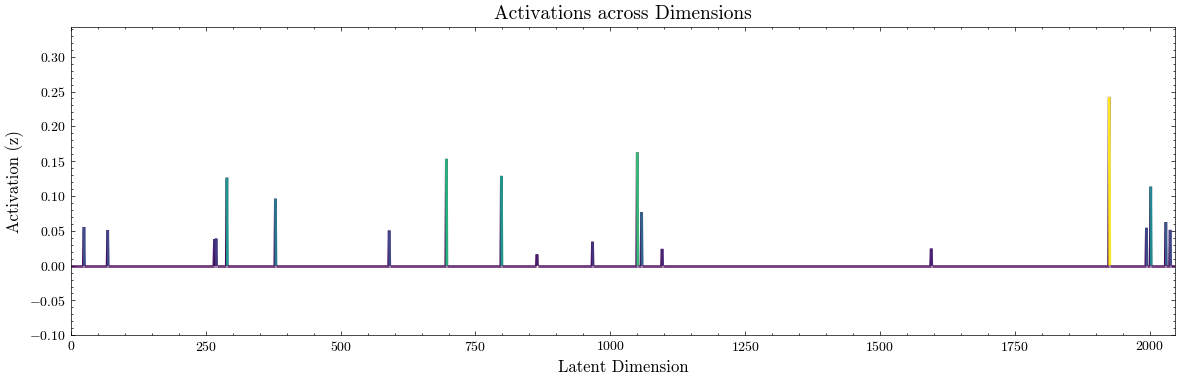

In [15]:
plotActivation(latents)